#   [Py4Hw User Guide](../UserGuide.ipynb)> 8.1 Dealing with unique instances, unique blocks and parametetric blocks


In classic HDL languages you usually create an HDL design file that contains a module.
Diferents levels of complexity can affect a HDL module. The following list describe the typical levels you can find, by order of complexity.

- The module has a fixed interface, all input and output signals have a given width and no parameters exist
- Parameters are used to define wire widths or simple things such as constant values.
- Parameters are used in conjunction with generative clasules to create different hardware subcircuits depending on them

On the other hand, in py4hw the designer never specifies the widths of the signals, they are inferred during runtime when instantiating the circuit. This does not mean that the designer cannot enforce certain widths on signals, but this must be done during runtime (usually by raising exceptions when invalid parameters are observed).

Moreover, the interface of circuits is totally defined during runtime. This means that in some circumstances a circuit can create some few inputs and outputs and in other circumstances can create hundreds of them. This flexibility is not present in many HDL frameworks, with some exceptions. For instance, this is possible in Chisel.


The challenge, then, is : how to procude RTL from those generic py4hw descriptions?

The easy option _currently implemented_ is to generate a different RTL file for each logic instance of the circuit.

This option has the negative effect of generating very large HDL descriptions with unnecessary simple circuit duplications. 

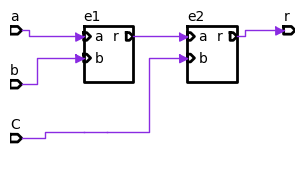

In [4]:
import py4hw

class ExampleChild(py4hw.Logic):
    def __init__(self, parent, name, a, b, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addOut('r', r)
        
        py4hw.And2(self, 'r', a, b, r)


class Example(py4hw.Logic):
    def __init__(self, parent, name, a, b, c, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addIn('C', c)
        self.addOut('r', r)
        
        d = self.wire('d', r.getWidth())
        
        ExampleChild(self, 'e1', a, b, d)
        ExampleChild(self, 'e2', d, c, r)

sys = py4hw.HWSystem()

a = sys.wire('a')
b = sys.wire('b')
c = sys.wire('c')
r = sys.wire('r')

dut = Example(sys, 'example', a, b, c,r)

py4hw.Schematic(dut).drawAll()

If we generate the Verilog for this circuit multiple modules will be generated for each instance of the child element.
This happens because py4hw does not know is this child circuit is exactly the same. 

In [5]:
rtl = py4hw.VerilogGenerator(dut)
print(rtl.getVerilogForHierarchy())

// This file was automatically created by py4hw RTL generator
module Example (
	input  a,
	input  b,
	input  C,
	output  r);
wire w_d;

ExampleChild_253625fdb40 i_e1(.a(a),.b(b),.r(w_d));
ExampleChild_253625fdb10 i_e2(.a(w_d),.b(C),.r(r));
endmodule

// This file was automatically created by py4hw RTL generator
module ExampleChild_253625fdb40 (
	input  a,
	input  b,
	output  r);

assign r = a & b;
endmodule

// This file was automatically created by py4hw RTL generator
module ExampleChild_253625fdb10 (
	input  a,
	input  b,
	output  r);

assign r = a & b;
endmodule



### Structure Names ###

A method to avoid this is that the designer provides a unique name (structure name) for every combination of parameters that should create a reusable module to avoid creating a module for every instance.
In the former example we could do:

// This file was automatically created by py4hw RTL generator
module Example (
	input  a,
	input  b,
	input  C,
	output  r);
wire w_d;

Child1 i_e1(.a(a),.b(b),.r(w_d));
Child1 i_e2(.a(w_d),.b(C),.r(r));
endmodule

// This file was automatically created by py4hw RTL generator
module Child1 (
	input  a,
	input  b,
	output  r);

assign r = a & b;
endmodule



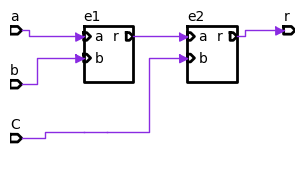

In [8]:
class ExampleChild(py4hw.Logic):
    def __init__(self, parent, name, a, b, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.r = self.addOut('r', r)
        
        py4hw.And2(self, 'r', a, b, r)
        
    def structureName(self):
        return 'Child{}'.format(r.getWidth())


class Example(py4hw.Logic):
    def __init__(self, parent, name, a, b, c, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addIn('C', c)
        self.addOut('r', r)
        
        d = self.wire('d', r.getWidth())
        
        ExampleChild(self, 'e1', a, b, d)
        ExampleChild(self, 'e2', d, c, r)

sys = py4hw.HWSystem()

a = sys.wire('a')
b = sys.wire('b')
c = sys.wire('c')
r = sys.wire('r')

dut = Example(sys, 'example', a, b, c,r)

py4hw.Schematic(dut).drawAll()

rtl = py4hw.VerilogGenerator(dut)
print(rtl.getVerilogForHierarchy())